## Import libraries

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import numpy as np
import random
import math
from google.colab.patches import cv2_imshow # for image display
import cv2
import time

## Read Image

In [3]:
def read_img(file_name,read_type = 0):  
  """
  Hàm đọc ảnh
  parameter:
    - file_name:string = url of file
    - read_type: int
               = 0 if read as gray image
               = 1 if read as color image
  """
  image = cv2.imread(file_name,read_type)
  return image

In [4]:
def show_img(file_name, read_type = 0):
  """
  Hàm hiển thị ảnh
  parameter:
    - file_name:string = url of file
    - read_type: int
                = 0 if read as gray image
                = 1 if read as color image
  """
  image = read_img(file_name, read_type)
  return cv2_imshow(image)

In [5]:
def write_img(file_name,image):
  return cv2.imwrite(file_name,image)

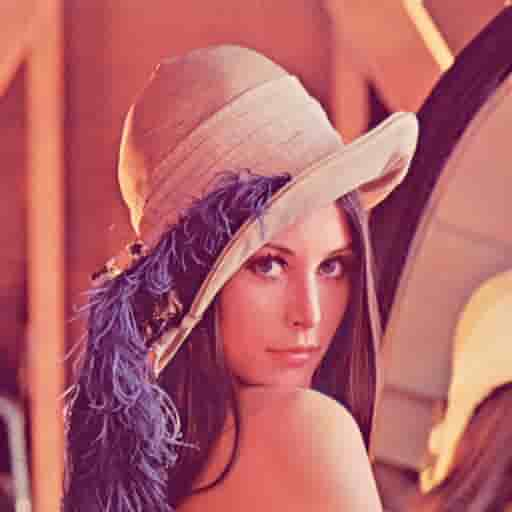

In [6]:
show_img("/content/drive/MyDrive/Colab Notebooks/lena.jpg",cv2.IMREAD_COLOR)

In [7]:
output_img = read_img("/content/drive/MyDrive/Colab Notebooks/lena.jpg",cv2.IMREAD_COLOR)
write_img("output.jpg",output_img)

True

In [8]:
srcImage = read_img("/content/drive/MyDrive/Colab Notebooks/lena.jpg",cv2.IMREAD_COLOR)
print(srcImage[0][0])
print(srcImage.shape)

[117 134 227]
(512, 512, 3)


## Triển khai thuật toán K-mean

In [9]:
#Hàm khởi tạo tâm cho từng Clusters
def InitClusters(srcImage, k=2) :
  """
  Hàm khởi tạo ngẫu nhiên k cụm

  parameter: - srcImage (2D array): mảng 2 chiều chứa các pixel đầu vào,mỗi pixel có kiểu float
             - k(int): số lượng cụm cần thực hiện 
  return: mảng chứa danh sách tâm của K cụm
  """
    # vector clusters chứa kết quả trả về
  centers = []

    # Lấy giá trị kích thước ảnh
  shape = srcImage.shape
  num_pixels = shape[0]

    # Khởi tạo theo số cụm cluster đã khai báo
  for i in range(k):
      center = []
      rand = random.randint(0,num_pixels - 1)
      center = srcImage[rand] 

        # Thêm cluster thứ index vào vector
      centers.append(center)

    # Trả về vector cluster đã được khởi tạo
  return centers

# Hàm tính khoảng khác biệt giữa 2 pixel bằng công thức Euclid
def EuclideanDistance (pixel1, pixel2, dim):
  """
  Hàm tính khoảng cách Euclid giữa 2 pixel bất kì
  parameter: - pixel1: pixel thứ nhất
             - pixel2: pixel thứ hai
             - dim: số kênh màu của pixel
  return: số thực (float) cho biết khoảng cách Euclid giữa 2 pixel
  """
  result = 0.0
  for i in range(0, dim) :
    result += abs(pixel1[i] - pixel2[i])
  return result

#Lấy giá trị trung bình của cluster đối với ảnh có 1 kênh màu
def meanCluster(srcImage, pixels, label):
    """
    Hàm tính trung bình của Cụm dựa vào nhãn của Cụm
    parameter: - srcImage (2D array): mảng 2 chiều chứa các pixel đầu vào,mỗi pixel có kiểu float
               - pixels (2D array): mảng 2 chiều chứa giá trị nhãn của mỗi pixel
               - label (int): Nhãn của cụm cần tính trung bình
    return: mảng chứa giá trị trung bình của cụm có nhãn đang xét
    """
    temp = []
    
    # Lấy kích thước của ảnh đầu vào
    shape = srcImage.shape
    num_pixel = shape[0]
    dim = shape[1] 

    result = [255.0]*dim
    # Duyệt qua ảnh đầu vào 
    for px in range(num_pixel):
      if (pixels[px] == label):
        temp.append(srcImage[px])

    temp_size = len(temp)
    # đối với ảnh 1 kênh màu
    if (dim == 1):       
		# Tính tổng giá trị của vector temp
      sum = 0.0
      for k in range(0,temp_size) :
        sum += temp[k]
        # Trả về giá trị trung bình của vector temp
      if (temp_size > 0):
        result[0] = sum / temp_size
      return result
     # Đối với ảnh 3 kênh màu
    elif (dim ==3):
      sumB = 0.0
      sumG = 0.0
      sumR = 0.0
    
      for k in range(0,temp_size):
        
        sumR += temp[k][0]
        sumG += temp[k][1]
        sumB += temp[k][2]
        # Trả về giá trị trung bình của vector temp
      if (temp_size > 0):
        result[0] = sumR/temp_size
        result[1] = sumG/temp_size
        result[2] = sumB/temp_size
      return result

In [10]:
def apply(srcImage, k=2, max_iter = -1, percis = 1.0):
  """
  Hàm phân lớp

  srcImage (2D array): mảng 2 chiều chứa các pixel đầu vào,mỗi pixel có kiểu float
  k(int): số lượng cụm cần thực hiện
  max_iter (int): Số vòng lặp tối đa
  percis (float): độ dịch chuyển tối thiểu giữa tâm của cụm mới so với tâm cụm cũ

  return: - labels: mảng chứa label của từng pixel
          - clusters: mảng chứa tâm của các cụm sau khi thực hiện hàm
          - dstImage: mảng chứa các giá trị đã được phân cụm
  """
  start_time = time.time()  
  print("k= " ,k, "max_iter = ",max_iter)
  dstImage = srcImage.copy()  #Tạo ảnh đích từ ảnh ban đầu

  clusters = InitClusters(srcImage, k)  #Khởi tạo K cụm ngẫu nhiên từ ảnh gốc

  shape = srcImage.shape   
  print("shape: ", shape, shape[0])  
  num_pixel = shape[0]           #Số lượng pixel
  dim = shape[1]            #Số kênh màu
  labels = [-1]*num_pixel   #Khởi tạo mảng labels chứa label của từng pixel      

  index = 0                 #index là giá trị chỉ mục của pixel đang duyệt,  khởi tạo  = 0
  prevs = []                #prevs là mảng các tâm của cụm lúc trước, khởi tạo = []

  while (True):  
    prevs = [{}]*k                                #Bắt đầu phân cụm
    for i in range(k):
      prevs[i] = clusters[i].copy()                          #Gán list cluster trước bằng list cluster hiện tại
    for pixl in range(0,num_pixel):     #Duyệt từng pixel một
      minDiff = 0             #Khởi tạo minDiff = 0
      minDiff = EuclideanDistance(srcImage[pixl], clusters[0], dim)        #minDiff = khoảng cách Euclid giữa pixel[i][j] với cụm thứ nhất

      diff = 0                #Khởi tạo diff = 0
      label = 0               #Nhãn của cụm label= 0

      for k_idx in range(1, len(clusters)):      #Duyệt từng cụm
        diff = EuclideanDistance(srcImage[pixl], clusters[k_idx], dim)      #Tính khoảng cách Euclid giữa pixel hiện tại với cụm thứ k
        if (diff < minDiff):  #Nếu khoảng cách nhỏ hơn minDiff
          minDiff = diff      #Gán minDiff = khoảng cách hiện tại
          label = k_idx           #Gán nhãn gần nhất cho pixel đang xét là nhãn của cụm thứ k
      labels[pixl] = label      #gán nhãn cho pixel[i][j] 
    for k_idx in range(0, len(clusters)):   #Duyệt từng cụm
      clusters[k_idx] = meanCluster(srcImage, labels, k_idx)                                               #Tính lại giá trị trung tâm cho từng cụm
    if (index > 0):
      cambiati = 0                         #Khởi tạo biến so sánh sự thay đổi giữa tâm của cụm cũ và cụm mới
      move_unit = 0.0
      for k_idx in range(0, len(clusters)):   #Duyệt từng cụm
        prev_px = prevs[k_idx]
        clus_px = clusters[k_idx]
        for dimen in range(dim):
          if (abs(prev_px[dimen] - clus_px[dimen]) > 0.001 ):
            cambiati += 1
            break
        move_unit += EuclideanDistance(prev_px, clus_px, dim) 
      
      if (cambiati == 0) or (move_unit <= percis):   #Nếu biến so sánh bằng 0 chứng tỏ trung tâm các cụm không thay đổi và thoát vòng lặp
        break

    index += 1   #Tăng chỉ mục lên 1
    if (max_iter > 0) and (index >= max_iter) :
      break

  for pixl in range(num_pixel):        
      dstImage[pixl] = clusters[labels[pixl]]
  print("--- %s seconds ---" % (time.time() - start_time))
  return labels, clusters, dstImage

In [12]:
input_img = cv2.cvtColor(srcImage, cv2.COLOR_BGR2RGB)
pixel_vals = input_img.reshape((-1,3))
  
# Convert to float type
pixel_vals = np.float32(pixel_vals)
labels, clusters, dstImage  = apply(pixel_vals, 4, 10, 1.0)

# Chuyển đổi định dạng output để hiển thị ảnh
centers = np.uint8(clusters)
segmented_data = centers[labels]

k=  4 max_iter =  10
shape:  (262144, 3) 262144
--- 107.13336896896362 seconds ---


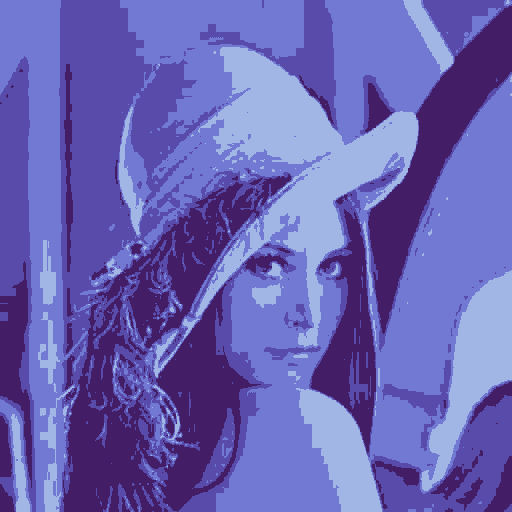

In [13]:
segmented_image = segmented_data.reshape((input_img.shape))
cv2_imshow(segmented_image)

In [24]:
image_cv2 = cv2.cvtColor(srcImage, cv2.COLOR_BGR2RGB)

pixel_vals_cv2 = srcImage.reshape((-1,3))
  
# Convert to float type
pixel_vals_cv2 = np.float32(pixel_vals_cv2)

criteria_cv2 = (cv2.TERM_CRITERIA_MAX_ITER, 10, 1.0)
  
# then perform k-means clustering wit h number of clusters defined as 3
#also random centres are initally chosed for k-means clustering
k = 4
retval_cv2, labels_cv2, centers_cv2 = cv2.kmeans(pixel_vals_cv2, k, None, criteria_cv2, 10, cv2.KMEANS_RANDOM_CENTERS)
  
# convert data into 8-bit values
centers_cv2 = np.uint8(centers_cv2)
segmented_data_cv2 = centers[labels_cv2.flatten()]
  
# reshape data into the original image dimensions
segmented_image_cv2 = segmented_data_cv2.reshape((image_cv2.shape))



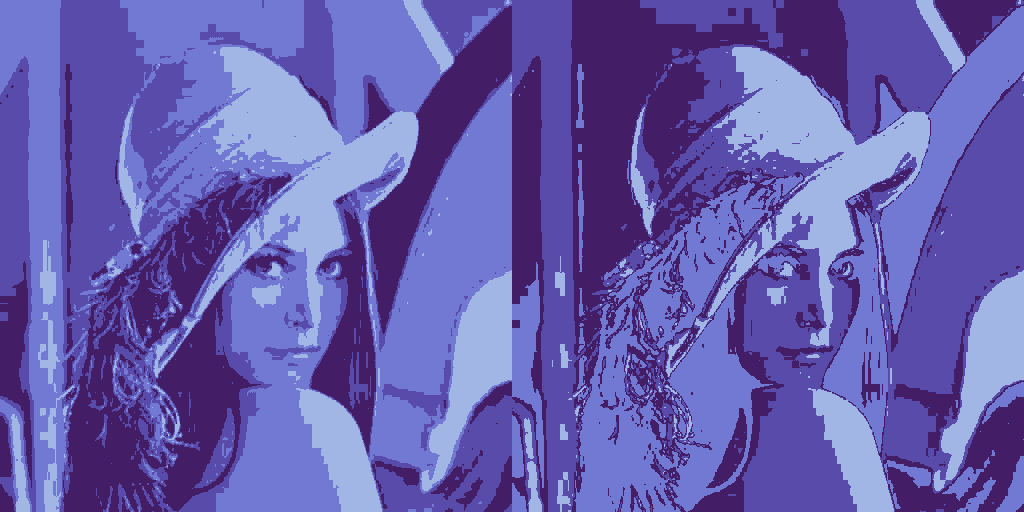

In [25]:
final_frame = cv2.hconcat((segmented_image, segmented_image_cv2))
cv2_imshow(final_frame)

### Các hàm tính độ lỗi



In [31]:

def errorClusterMove (clusters_1, clusters_2, dim):
  """
  Hàm tính tổng sai số Euclide giữa các tâm của cụm

  cluster_1 : mảng chứa danh sách các tâm của các cụm thứ nhất
  cluster_1 : mảng chứa danh sách các tâm của các cụm thứ hai
  dim: số nguyên chỉ số kênh màu của ảnh đầu vào

  return: err (float): tổng sai số Euclide giữa các tâm của cụm
  """
  err = 0.0
  for i in range(0, len(clusters_1)):
    err += EuclideanDistance(clusters_1[i],clusters_2[i], dim)
  return err
def errorClusterLabel (labels_1, labels_2):
  """
  Hàm tính tỷ lệ sai số giữa nhãn của các nhóm
  cluster_1 : mảng chứa danh sách các tâm của các cụm thứ nhất
  cluster_1 : mảng chứa danh sách các tâm của các cụm thứ hai

  return: result (float): tỷ lệ sai số giữa nhãn của các nhóm
  """
  num_pixel = len(labels_1)
  result = 0.0
  for i in range(num_pixel):
    if (labels_1[i] != labels_2[i]):
      result += 1.0
  return result/num_pixel
      

In [32]:
print("error of Cluster:", errorClusterLabel(labels,labels_cv2))

error of Cluster: 0.8529853820800781


In [33]:
print("error of center:", errorClusterMove(centers,centers_cv2,3))

error of center: 1514.0


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:40: RuntimeWarning: overflow encountered in ubyte_scalars
